<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [2]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [25]:
drive.mount('/content/drive')
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx',
               'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m',
               'R_d_w_l', 'phase', 'L_t_m', 'L_t_l',
               'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
data = markov_t6.iloc[1275:]
# Remover linhas onde R_w_l é zero
data = data.loc[data['R_w_l'] != 0]

# 2º Passo: Cálculo (Markov 6, Dados Completos)

In [26]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
# Dados de Bh (por fase)
Bh_values = np.array([2, 1.2, 1.2, 4, 1.5])  # Exemplo para 5 fases

# Calcule τi e sua derivada
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i']) / np.gradient(data['t'])

# Calcule τr_desejado (para cada fase)
data['tau_r_desejado'] = -data['tau_i'] - (Bh_values / Ba) * data['d_tau_i']

# 3º Passo: Separação e Normalização dos dados


In [27]:
dataset = data.copy()
X = dataset[['R_t_p', 'R_t_l', 'R_w_p', 'R_w_l', 'phase']]  # Inputs
y = dataset[['R_T_d']]  # Saída: torque desejado (já calculado pelo sistema)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [30]:
timesteps = 350  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9143, 350, 5)
Forma dos dados de saída: (9143, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [31]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(timesteps, n_features)))
model_lstm.add(Dropout(0.2))  # Dropout reduzido para 20%

model_lstm.add(LSTM(64, return_sequences=False))  # Camada final com 32 unidades
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1))  # Saída de um único valor (tau_r)

# Compilar o modelo com Huber loss e Adam com learning rate ajustado
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),
    metrics=['MAE', 'MSE'])

# Resumo do modelo
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 350, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 350, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [40]:
history = model_lstm.fit(
    X_train, y_train,
    epochs=64,
    batch_size=32,
    validation_split=0.4,
    verbose = 1
)

Epoch 1/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 125s 727ms/step - MAE: 0.0340 - MSE: 0.0021 - loss: 0.0010 - val_MAE: 0.0621 - val_MSE: 0.0073 - val_loss: 0.0036
Epoch 2/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 160s 835ms/step - MAE: 0.0331 - MSE: 0.0020 - loss: 9.8309e-04 - val_MAE: 0.0673 - val_MSE: 0.0082 - val_loss: 0.0041
Epoch 3/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 204s 846ms/step - MAE: 0.0311 - MSE: 0.0017 - loss: 8.4795e-04 - val_MAE: 0.0582 - val_MSE: 0.0063 - val_loss: 0.0032
Epoch 4/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 180s 715ms/step - MAE: 0.0306 - MSE: 0.0017 - loss: 8.4381e-04 - val_MAE: 0.0483 - val_MSE: 0.0042 - val_loss: 0.0021
Epoch 5/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 145s 737ms/step - MAE: 0.0312 - MSE: 0.0018 - loss: 9.0319e-04 - val_MAE: 0.0581 - val_MSE: 0.0060 - val_loss: 0.0030
Epoch 6/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 146s 850ms/step - MAE: 0.0303 - MSE: 0.0017 - loss: 8.2969e-04 - val_MAE: 0.0637 - val_MSE: 0.0068 - val_loss: 0.0034
Epoch 7/64
172/172 ━━━━━━━━━━━━━━━━━━━━ 125s 730ms/step 

# 7º Passo: Avaliação e Previsão

In [41]:
y_pred_scaled = model_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step
R²: 0.9335965197857772
MAE: 0.2927 Nm
RMSE: 0.4716 Nm


# 8º Passo: Visualização das perdas (train vs validation)

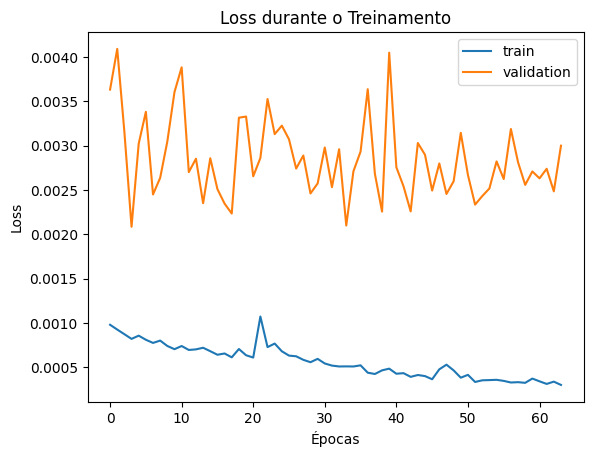

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

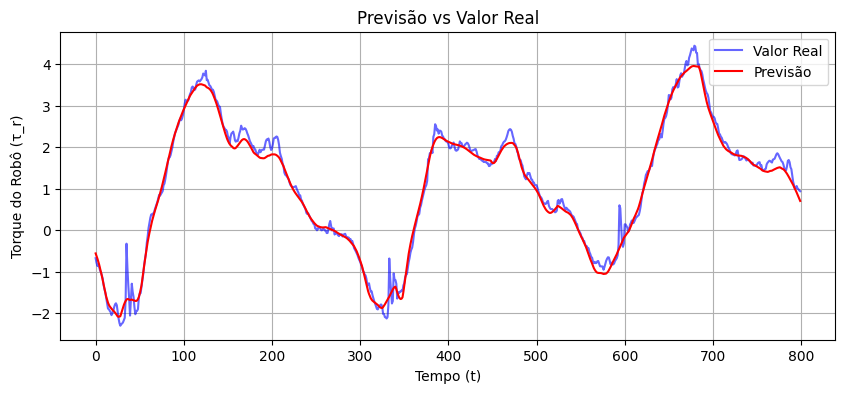

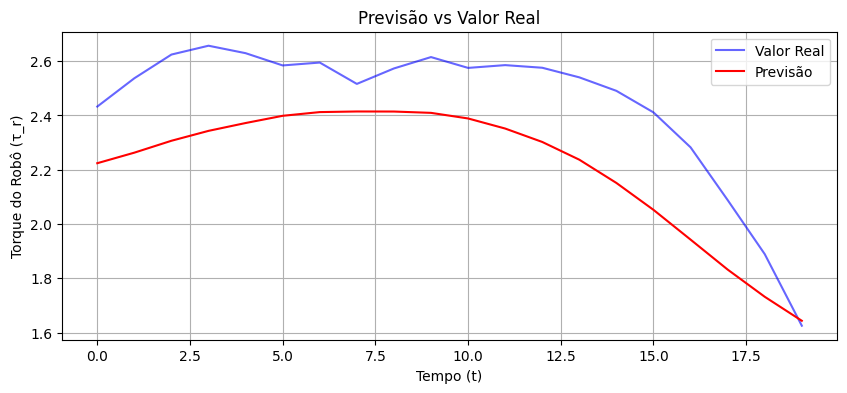

In [43]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='-', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[1500:2300], y_pred[1500:2300])
plot_predictions(y_train_rescaled[400:420], y_pred[400:420])



# 10º Passo: Erro

In [44]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

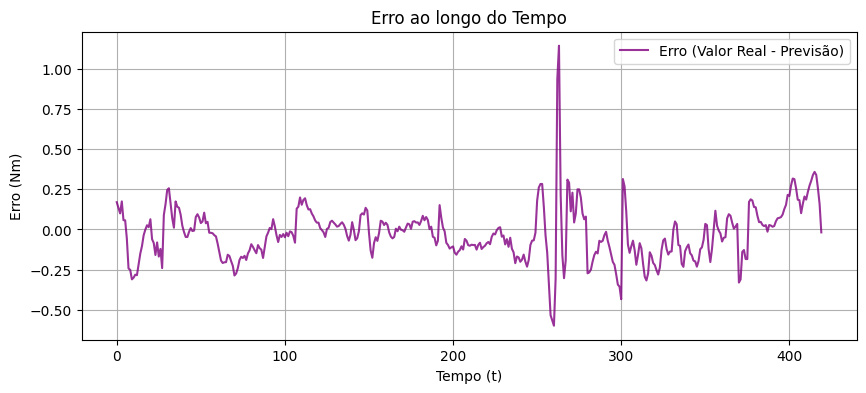

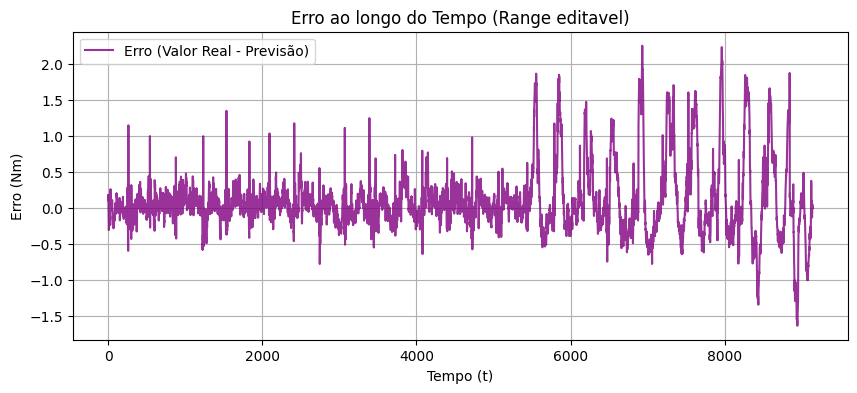

Média do Erro: 0.0942 Nm
Desvio Padrão do Erro: 0.4621 Nm


In [45]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:420], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/py


Estatísticas do Torque de Interação:
- τ_i esperado médio: 605935896887.65 Nm
- τ_i previsto médio: -74.95 Nm
- MAE: 80419168526575.1875 Nm
- RMSE: 154810189367422.5000 Nm



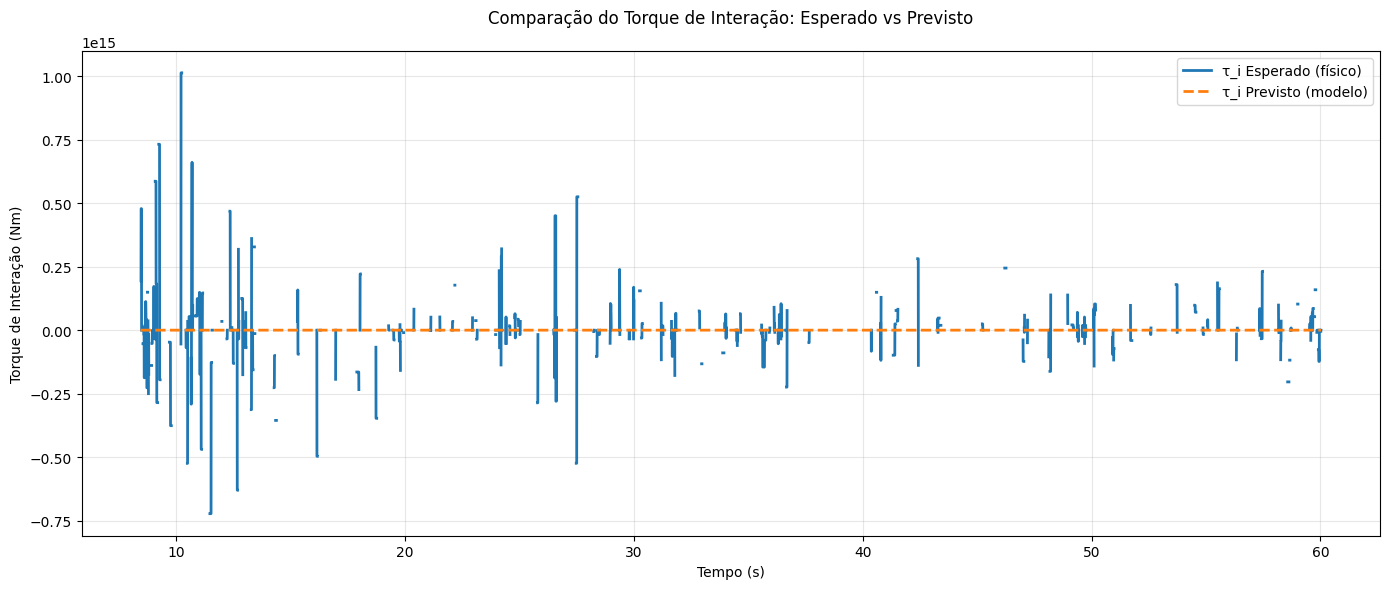

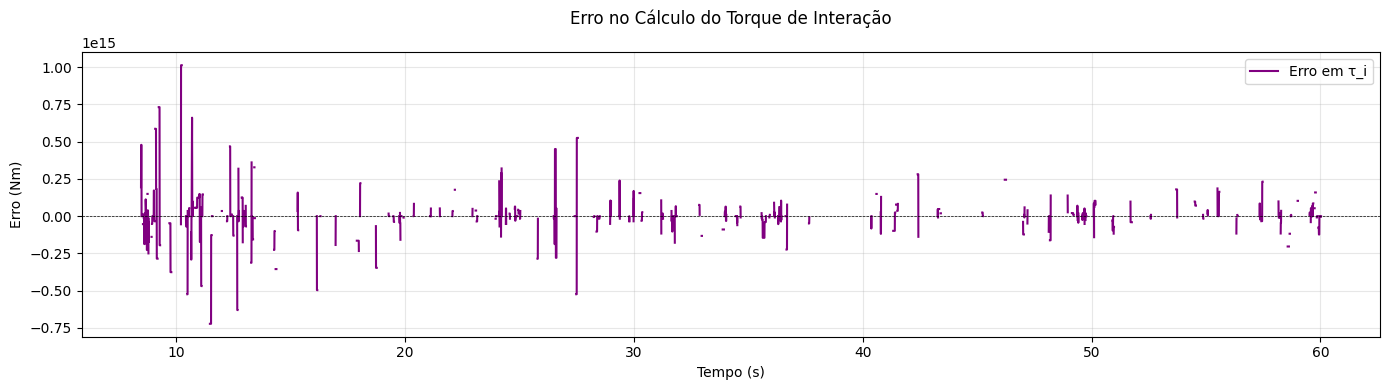

In [46]:
# 12º Passo: Cálculo do Torque de Interação (τ_i) - Versão Corrigida e Completa

# Parâmetros do sistema
Ks = 105      # [Nm/rad] Rigidez do exoesqueleto
Nr = 150      # [] Redução do motor
Ka = 200      # [Nm/rad] Rigidez do acessório
Ba = 10       # [Nms/rad] Amortecimento do acessório
Bh_values = np.array([2, 1.2, 1.2, 4, 1.5])  # Bh por fase

# Criar DataFrame com resultados do modelo
results = pd.DataFrame({
    'Time': data['t'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'Real_R_T': y_train_rescaled.flatten(),
    'Predicted_R_T': y_pred.flatten(),
    'R_t_m': data['R_t_m'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_l': data['R_t_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_p': data['R_t_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_p': data['R_w_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_l': data['R_w_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'phase': data['phase'].iloc[timesteps:timesteps+len(y_train_rescaled)].values
})

# 1. Cálculo das variáveis angulares
results['phi_r'] = results['R_t_l']          # Ângulo da coroa [rad]
results['phi_h'] = results['R_t_p']          # Ângulo humano [rad]
results['phi_m'] = results['R_t_m']          # Ângulo do motor [rad]
results['phi_w'] = results['phi_m'] / Nr     # Ângulo pós-redução [rad]

# 2. Cálculo das derivadas temporais (método robusto)
dt = np.gradient(results['Time'])
results['dphi_r'] = np.gradient(results['phi_r'], dt)  # [rad/s]
results['dphi_h'] = np.gradient(results['phi_h'], dt)  # [rad/s]

# 3. Torque de interação ESPERADO (fórmula física)
results['tau_i_esperado'] = Ka * (results['phi_r'] - results['phi_h']) + Ba * (results['dphi_r'] - results['dphi_h'])

# 4. Torque do robô PREVISTO (a partir do modelo LSTM)
results['tau_r_previsto'] = results['Predicted_R_T']

# 5. Torque de interação PREVISTO (solução numérica implícita)
tau_i_previsto = np.zeros(len(results))
Bh_map = {i: Bh_values[i] for i in range(5)}  # Mapeamento fase → Bh

for i in range(1, len(results)):
    current_phase = int(results['phase'].iloc[i])
    Bh = Bh_map.get(current_phase, 2.0)  # Default 2.0 se fase não mapeada
    dt = results['Time'].iloc[i] - results['Time'].iloc[i-1]

    # Método implícito (Euler backward)
    tau_i_previsto[i] = (tau_i_previsto[i-1] - results['tau_r_previsto'].iloc[i] * dt * Ba) / (1 + (Bh/Ba)*dt)

results['tau_i_previsto'] = tau_i_previsto

# 6. Análise de erros
results['erro_tau_i'] = results['tau_i_esperado'] - results['tau_i_previsto']
print(f'''
Estatísticas do Torque de Interação:
- τ_i esperado médio: {np.mean(results['tau_i_esperado']):.2f} Nm
- τ_i previsto médio: {np.mean(results['tau_i_previsto']):.2f} Nm
- MAE: {np.mean(np.abs(results['erro_tau_i'])):.4f} Nm
- RMSE: {np.sqrt(np.mean(results['erro_tau_i']**2)):.4f} Nm
''')

# 7. Visualização
plt.figure(figsize=(14, 6))
plt.plot(results['Time'], results['tau_i_esperado'], label='τ_i Esperado (físico)', linewidth=2)
plt.plot(results['Time'], results['tau_i_previsto'], label='τ_i Previsto (modelo)', linestyle='--', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Torque de Interação (Nm)')
plt.title('Comparação do Torque de Interação: Esperado vs Previsto', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Visualização do erro
plt.figure(figsize=(14, 4))
plt.plot(results['Time'], results['erro_tau_i'], label='Erro em τ_i', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Erro (Nm)')
plt.title('Erro no Cálculo do Torque de Interação', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

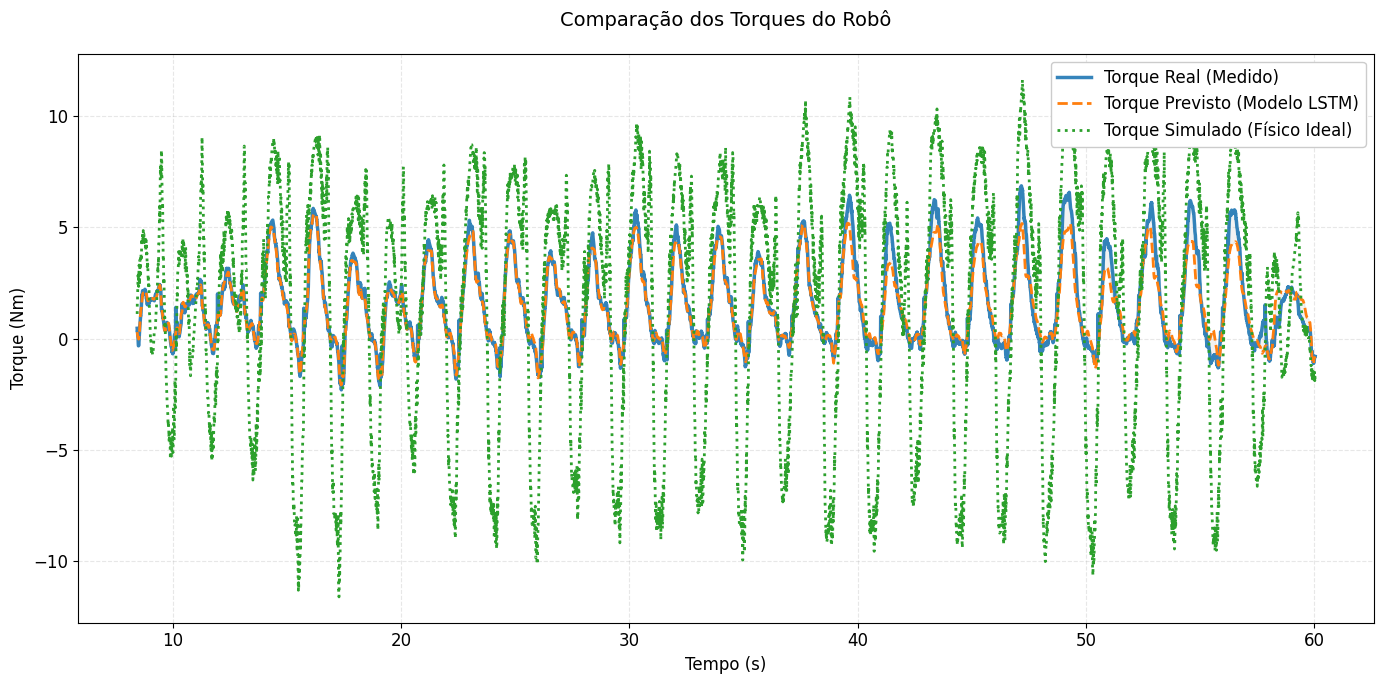


Estatísticas Comparativas:
Métrica                         Real   Previsto   Simulado
-------------------------------------------------------
Média (Nm)                      1.47       1.37       1.55
Desvio Padrão (Nm)              1.83       1.58       5.54
Correlação com Real                -       0.97       0.80


In [47]:
# 12º Passo: Cálculo e Visualização dos Torques Comparativos

# Parâmetros do sistema
Ks = 105      # [Nm/rad] Rigidez do exoesqueleto
Nr = 150      # [] Redução do motor
Ka = 200      # [Nm/rad] Rigidez do acessório
Ba = 10       # [Nms/rad] Amortecimento do acessório
Bh_values = np.array([2, 1.2, 1.2, 4, 1.5])  # Bh por fase

# Criar DataFrame com todos os resultados
results = pd.DataFrame({
    'Time': data['t'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'Real_R_T': y_train_rescaled.flatten(),      # Torque real medido
    'Predicted_R_T': y_pred.flatten(),           # Torque previsto pelo modelo
    'R_t_m': data['R_t_m'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_l': data['R_t_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_t_p': data['R_t_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_p': data['R_w_p'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'R_w_l': data['R_w_l'].iloc[timesteps:timesteps+len(y_train_rescaled)].values,
    'phase': data['phase'].iloc[timesteps:timesteps+len(y_train_rescaled)].values
})

# 1. Cálculo do torque do robô SIMULADO (físico ideal)
results['phi_w'] = results['R_t_m'] / Nr  # Ângulo pós-redução
results['tau_r_simulado'] = Ks * (results['phi_w'] - results['R_t_l'])

# 2. Configuração do gráfico
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 12})

# 3. Plot das três curvas de torque
plt.plot(results['Time'], results['Real_R_T'],
         label='Torque Real (Medido)',
         color='#1f77b4', linewidth=2.5, alpha=0.9)

plt.plot(results['Time'], results['Predicted_R_T'],
         label='Torque Previsto (Modelo LSTM)',
         color='#ff7f0e', linestyle='--', linewidth=2)

plt.plot(results['Time'], results['tau_r_simulado'],
         label='Torque Simulado (Físico Ideal)',
         color='#2ca02c', linestyle=':', linewidth=2)

# 4. Configurações do gráfico
plt.title('Comparação dos Torques do Robô', pad=20, fontsize=14)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Torque (Nm)', fontsize=12)
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, linestyle='--', alpha=0.3)

# 5. Limites do eixo y (ajuste conforme seus dados)
ymin = min(results['Real_R_T'].min(), results['Predicted_R_T'].min(), results['tau_r_simulado'].min()) * 1.1
ymax = max(results['Real_R_T'].max(), results['Predicted_R_T'].max(), results['tau_r_simulado'].max()) * 1.1
plt.ylim(ymin, ymax)

# 6. Destaque para áreas importantes (opcional)
plt.fill_between(results['Time'], results['Real_R_T'], results['Predicted_R_T'],
                 color='gray', alpha=0.1, label='Diferença Real-Previsto')

plt.tight_layout()
plt.show()

# 7. Estatísticas comparativas
print('\nEstatísticas Comparativas:')
print(f"{'Métrica':<25} {'Real':>10} {'Previsto':>10} {'Simulado':>10}")
print(f"{'-'*55}")
print(f"{'Média (Nm)':<25} {np.mean(results['Real_R_T']):>10.2f} {np.mean(results['Predicted_R_T']):>10.2f} {np.mean(results['tau_r_simulado']):>10.2f}")
print(f"{'Desvio Padrão (Nm)':<25} {np.std(results['Real_R_T']):>10.2f} {np.std(results['Predicted_R_T']):>10.2f} {np.std(results['tau_r_simulado']):>10.2f}")
print(f"{'Correlação com Real':<25} {'-':>10} {np.corrcoef(results['Real_R_T'], results['Predicted_R_T'])[0,1]:>10.2f} {np.corrcoef(results['Real_R_T'], results['tau_r_simulado'])[0,1]:>10.2f}")